In [131]:
%matplotlib inline
import numpy as np
from scipy.sparse.linalg import LinearOperator, svds, aslinearoperator
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler
from pysgpp import DataMatrix, DataVector, createOperationMultipleEval, Grid
from __future__ import division, print_function

import matplotlib.pyplot as plt
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, to_data_matrix, split

In [94]:
grid = Grid.createModLinearGrid(8)
gen = grid.getGenerator()
storage = grid.getStorage()
gen.regular(3)

df = get_dataset('concrete')
train, test = split(df)
X_train, y_train = get_xy(train)
X_test, y_test = get_xy(train)

In [95]:
def eval_op(x, op, size):
    result_vec = DataVector(size)
    x = DataVector(np.array(x).flatten())
    op.mult(x, result_vec)
    return result_vec.array().copy()

def eval_op_transpose(x, op, size):
    result_vec = DataVector(size)  
    x = DataVector(np.array(x).flatten())
    op.multTranspose(x, result_vec)
    return result_vec.array().copy()
  
data_train = to_data_matrix(X_train)
data_test = to_data_matrix(X_test)

num_elem = X_train.shape[0]

op = createOperationMultipleEval(grid, data_train)
matvec = lambda x: eval_op(x, op, num_elem)
rmatvec = lambda x: eval_op_transpose(x, op, grid.getSize())

shape = (num_elem, grid.getSize())
linop = LinearOperator(shape, matvec, rmatvec, dtype='float64')

y_sg = np.matrix(y_train).T
x_sg = np.matrix(np.zeros(grid.getSize())).transpose()

In [96]:
u, s, v = svds(linop, k=grid.getSize() - 1)
#A_sg = np.matrix(((u * s) * np.matrix(v)))

# FISTA

## Proximal operator & splitting

(see proximal algorithms boyd)

$$
f(x) = (1/2)\Vert Ax - b \Vert_2^2, \qquad g(x) = \lambda \Vert x \Vert_1 \\
\nabla f(x) = A^\text{T}(Ax-b) \\
\text{prox}_{\lambda g}(x) = ( x - \lambda)_+ - (-x - \lambda)_+
\\
$$

Note: get_residual calculates $\Vert Ax - b \Vert_2^2$, note the missing $1/2$.
All calculations use the adjusted value $1/2 * \text{ residual}$

In [120]:
def array_to_linop(A):
    matvec_A = lambda x: A*x
    rmatvec_A = lambda x: A.transpose()*x
    linop = LinearOperator(A.shape, matvec_A, rmatvec_A, dtype='float64')
    return linop

def proximal_l1(x, alpha):
    return np.maximum(x - alpha, 0) - np.maximum(-x - alpha, 0)

def gradient(A, x, b):
    if isinstance(A, np.matrix):
        return A.transpose() * (A * x - b)
    elif isinstance(A, LinearOperator):
        return (A.rmatvec(A.matvec(x) - b))
    
def get_stepsize(A):
    if isinstance(A, np.matrix):
        singular_values = svd(A, compute_uv=False)
        max_sval_A = singular_values.max()      
    elif isinstance(A, LinearOperator):
        _, singular_values, _ = svds(A, k=1)
        max_sval_A = singular_values.max()    
    max_eigen_AA_t = max_sval_A * max_sval_A
    return 1.0/(max_eigen_AA_t)


def get_residual(A, x, b):
    if isinstance(A, np.matrix):
        res = A * x - b
    elif isinstance(A, LinearOperator):
        res = A.matvec(x) - b
    res = np.multiply(res, res)
    return res.sum()


def ista(A, x_start, num_it, lambda_reg, b, residuals=None):
    x_k = x_start
    stepsize = get_stepsize(A)
    for i in xrange(1,num_it+1):
        x_k = proximal_l1(x_k - stepsize * gradient(A, x_k, b), lambda_reg * stepsize)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
        if residuals is not None:
            residuals.append(get_residual(A, x_k, b))    
    return x_k


def fista(A, x_start, num_it, lambda_reg, b, residuals=None):
    stepsize = get_stepsize(A)
    x_k = x_start
    y_k = x_k.copy()
    t_k = 1.0
    for i in xrange(1,num_it+1):
        x_before = x_k.copy()
        x_k = proximal_l1(y_k - stepsize * gradient(A, y_k, b), lambda_reg * stepsize)
        
        t_before = t_k
        t_k = (1 + np.sqrt(1 + 4 * t_before* t_before))/2
        
        y_k = x_k + ((t_before - 1)/(t_k)) * (x_k - x_before)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
            print(stepsize**(-1))
        if residuals is not None:
            residuals.append(get_residual(A, x_k, b))
    return x_k


def eval_goal(A, x, b, lambda_reg):
    res = 0.5*get_residual(A, x, b)
    regular = lambda_reg * np.abs(x).sum()
    return res + regular


def eval_upper_bound(A, x, y, b, lambda_reg, L_k):
    # FISTA paper eq. 2.5
    f = 0.5 * get_residual(A, y, b)
    g = lambda_reg * np.abs(x).sum()
    gradient_f = gradient(A, y, b)
    x_minus_y = x - y
    x_minus_y_norm = L_k/2 * np.multiply(x_minus_y, x_minus_y).sum()
    return f + np.dot(np.transpose(gradient_f), x_minus_y) + x_minus_y_norm + g
 
    
def ista_line(A, x, lambda_reg, b, L_before):
    i_k = 0
    eta = 2
    while True:
        L_k = eta**i_k * L_before
        stepsize = 1.0/L_k
        prox = proximal_l1(x - stepsize * gradient(A, x, b), lambda_reg * stepsize)
        goal = eval_goal(A, prox, b, lambda_reg)
        upper_bound = eval_upper_bound(A, prox, x, b, lambda_reg, L_k)
        if goal <= upper_bound:
            return L_k
        i_k += 1

        
def ista_back(A, x_start, num_it, lambda_reg, b):
    x_k = x_start
    L_k = 1.1
    for i in xrange(1,num_it+1):
        L_k = ista_line(A, x_k, lambda_reg, b, L_k)
        stepsize = 1.0/L_k
        x_k = proximal_l1(x_k - stepsize * gradient(A, x_k, b), lambda_reg * stepsize)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
    return x_k   

def fista_back(A, x_start, num_it, lambda_reg, b):
    L_k = 1.1
    x_k = x_start
    y_k = x_k.copy()
    t_k = 1.0
    for i in xrange(1,num_it+1):
        L_k = ista_line(A, x_k, lambda_reg, b, L_k)
        stepsize = 1.0/L_k
        
        x_before = x_k.copy()
        x_k = proximal_l1(y_k - stepsize * gradient(A, y_k, b), lambda_reg * stepsize)
        
        t_before = t_k
        t_k = (1 + np.sqrt(1 + 4 * t_before* t_before))/2
        
        y_k = x_k + ((t_before - 1)/(t_k)) * (x_k - x_before)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))            
            print(L_k)
    return x_k

In [121]:
A = np.matrix(np.random.rand(1000,800))
x = np.matrix(np.zeros((800,1)))
b = np.matrix(np.random.rand(1000,1))
lambda_reg = 0.0

In [122]:
%%time
x_ista = ista(A, x, 100, lambda_reg, b)

Iteration 10	 with residual of 84.7212461536
Iteration 20	 with residual of 84.1745858257
Iteration 30	 with residual of 83.6358990475
Iteration 40	 with residual of 83.105040569
Iteration 50	 with residual of 82.5818681172
Iteration 60	 with residual of 82.0662423307
Iteration 70	 with residual of 81.5580266958
Iteration 80	 with residual of 81.0570874837
Iteration 90	 with residual of 80.5632936896
Iteration 100	 with residual of 80.0765169728
CPU times: user 337 ms, sys: 0 ns, total: 337 ms
Wall time: 338 ms


In [8]:
%%time
x_ista = ista_back(A, x, 100, lambda_reg, b)

Iteration 10	 with residual of 87.7944812296
Iteration 20	 with residual of 87.4353393806
Iteration 30	 with residual of 87.0796289558
Iteration 40	 with residual of 86.7273077845
Iteration 50	 with residual of 86.3783342991
Iteration 60	 with residual of 86.0326675119
Iteration 70	 with residual of 85.690267007
Iteration 80	 with residual of 85.3510929315
Iteration 90	 with residual of 85.0151059869
Iteration 100	 with residual of 84.6822674207
CPU times: user 329 ms, sys: 1.58 ms, total: 331 ms
Wall time: 327 ms


In [127]:
lambda_reg = 0.001
x_fista = fista(linop,x_sg,1000,0, y_sg)

Iteration 100	 with residual of 22048.3957662
25517.0327502
Iteration 200	 with residual of 17929.5445658
25517.0327502
Iteration 300	 with residual of 16489.8873054
25517.0327502
Iteration 400	 with residual of 15786.1309342
25517.0327502
Iteration 500	 with residual of 15331.8965314
25517.0327502
Iteration 600	 with residual of 15002.8456168
25517.0327502
Iteration 700	 with residual of 14757.4930338
25517.0327502
Iteration 800	 with residual of 14553.6859607
25517.0327502
Iteration 900	 with residual of 14389.4749103
25517.0327502
Iteration 1000	 with residual of 14256.596737
25517.0327502


In [119]:
op_pred = createOperationMultipleEval(grid, data_test)
prediction = DataVector(X_test.shape[0])
op.mult(DataVector(np.array(x_fista).flatten()), prediction)
prediction = prediction.array()
mse = (prediction - y_test)
mse = np.multiply(mse, mse).sum()
mse/(X_test.shape[0])

17.301695069180493

array([ 637.53027552,  510.4750343 ,  400.05915888,  315.12969478,
        255.37851068,  215.59918954,  189.31065972,  170.9724484 ,
        156.81028507,  144.71412431,  133.73704067,  123.57038622,
        114.16814067,  105.54370391,   97.69185342,   90.57740384,
         84.14829359,   78.3508956 ,   73.13932394,   68.47770804,
         64.33740482,   60.69205198,   57.51314258,   54.76777411,
         52.41885089,   50.42690209,   48.75225169,   47.35655741,
         46.20338187,   45.25804241,   44.48724603,   43.85894132,
         43.34256727,   42.90963378,   42.53443617,   42.19469753,
         41.87199894,   41.55194171,   41.22405131,   40.88147083,
         40.52050704,   40.1400935 ,   39.74122813,   39.32643092,
         38.89925278,   38.4638523 ,   38.02464511,   37.58602263,
         37.15213328,   36.72671774,   36.31299131,   35.91356716,
         35.53041603,   35.16485846,   34.81758582,   34.48870599,
         34.17780865,   33.88404429,   33.60621088,   33.34284

In [169]:
lambda_reg = 0.001
residuals_fista = []
x_fista = fista(linop,x_sg,1000,lambda_reg, y_sg, residuals_fista)
residuals_ista = []
x_ista = ista(linop,x_sg, 1000, lambda_reg, y_sg, residuals_ista)
mse_fista = np.array(residuals_fista)/(X_test.shape[0])
mse_ista = np.array(residuals_ista)/(X_test.shape[0])

Iteration 100	 with residual of 22048.4085711
25517.0327502
Iteration 200	 with residual of 17929.5669305
25517.0327502
Iteration 300	 with residual of 16489.9237276
25517.0327502
Iteration 400	 with residual of 15786.1739829
25517.0327502
Iteration 500	 with residual of 15331.9424135
25517.0327502
Iteration 600	 with residual of 15002.89935
25517.0327502
Iteration 700	 with residual of 14757.5492318
25517.0327502
Iteration 800	 with residual of 14553.7481194
25517.0327502
Iteration 900	 with residual of 14389.5508917
25517.0327502
Iteration 1000	 with residual of 14256.6926007
25517.0327502
Iteration 100	 with residual of 46835.4046834
Iteration 200	 with residual of 35013.8201762
Iteration 300	 with residual of 31555.3612567
Iteration 400	 with residual of 29503.4010652
Iteration 500	 with residual of 28006.3829558
Iteration 600	 with residual of 26839.3318673
Iteration 700	 with residual of 25898.6968174
Iteration 800	 with residual of 25123.6488771
Iteration 900	 with residual of 2

In [172]:
x = range(0, 1000)

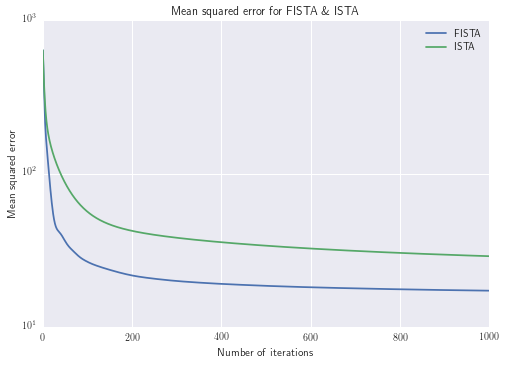

In [188]:
plt.rc('text', usetex=True)
sns.set_style('darkgrid')
fig = plt.figure(1)
ax = plt.subplot(111)
ax.semilogy(x, mse_fista)
ax.semilogy(x, mse_ista)
ax.set_title("Mean squared error for FISTA \& ISTA")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Mean squared error")
ax.legend(["FISTA", "ISTA"])
fig.savefig('fista.pdf', bbox_inches='tight')